# Exercise 8: Classification Pipeline

**Libaries needed: pandas, sklearn>=0.19, numpy, nltk, graphviz (python-graphviz), e.g.**
```
conda install graphviz
conda install python-graphviz
```

First, make sure your environment is setup with the right libraries. In this exercise, you should be filling the empty code sections, marked as `TODO:`

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Analyzing Weather Sentiments in Tweets

In this exercise, we consider the [Weather sentiment](https://data.world/crowdflower/weather-sentiment) dataset from [Crowdflower](https://www.crowdflower.com/).

To create this dataset, contributors were asked to grade the sentiment of a particular tweet relating to the weather. Contributors could choose among the following categories:
1. Positive
2. Negative
3. I can't tell
4. Neutral / author is just sharing information
5. Tweet not related to weather condition

The catch is that 20 contributors graded each tweet. Thus, in many cases contributors assigned conflicting sentiment labels to the same tweet. 

In the `data` directory, you will find the file [weather-non-agg-DFE.csv](data/weather-non-agg-DFE.csv) containing the raw contributor answers for each of the 1,000 tweets.


The fields of the csv file are as follows:
1. **_unit\_id_**: CrowdFlower’s numeric ID for the unit,
2. **channel**: channel via which the contributor entered the job,
3. **trust**: the contributor's accuracy level in the current job, determined by their accuracy on the Test Questions they’ve seen in the job,
4. **worker_id**: CrowdFlower Contributor ID,
5. **country**: worker's country code
6. **region**: worker's region
7. **city**: worker's city
8. **emotion**: worker's assigned emotion to the tweet
9. **tweet_id**: id of the tweet
10. **tweet_body**: body text of the tweet


Our goal in this exercise is to build a classifier that predicts the tweet's emotion according to the aforementioned categories. Towards that, we will be first aggregating the results of the crowdflower task in order to get a clean dataset. Then we will be preparing the data features by tokenizing the text. Finally, we will be inputting these features into a text classifier. 


### Task 1: Data Formatting

To begin with let's load the data into a format we can work with.



In [2]:
data = pd.read_csv('data/weather-non-agg-DFE.csv')
# print the shape of our data frame
print(data.shape)
data.head()

(20000, 10)


,_unit_id_,channel,trust,worker_id,country,region,city,emotion,tweet_id,tweet_body
0,314960382,clixsense,0.4541,18034918,IND,7,Delhi,Neutral / author is just sharing information,82846118,Fire Weather Watch issued May 17 at 4:21PM CDT...
1,314960385,clixsense,0.4541,18034918,IND,7,Delhi,Positive,82510997,Passing out now. working tonight. Storms toda...
2,314960391,clixsense,0.4541,18034918,IND,7,Delhi,Negative,83271279,"RT @mention: ""The storm is only that which aut..."
3,314960396,clixsense,0.4541,18034918,IND,7,Delhi,Positive,80058872,It is hot out here but it feels great
4,314960400,clixsense,0.4541,18034918,IND,7,Delhi,Neutral / author is just sharing information,80058809,I can't find a way to delete my iWitness Weath...


Let's see how our labels are distributed:

In [3]:
print("For all tweets:\n" + str(data.emotion.value_counts()))
print("For tweet_id=82846118:\n" + str(data[data.tweet_id==82846118].emotion.value_counts()))

For all tweets:
Neutral / author is just sharing information    5371
Negative                                        4986
Positive                                        4953
Tweet not related to weather condition          3553
I can't tell                                    1137
Name: emotion, dtype: int64
For tweet_id=82846118:
Neutral / author is just sharing information    16
Positive                                         1
I can't tell                                     1
Tweet not related to weather condition           1
Negative                                         1
Name: emotion, dtype: int64


### Task 2: Aggregating the Annotations

Now we will be aggregating the data of the workers to obtain one label per tweet. Your input is the pandas data frame `data`. Your output should be a data frame of 1000 rows, with one `emotion` field for each `tweet_id`. You should use the Majority Decision algorithm, where the value of `emotion` field is simply the one occurring most frequently per `tweet_id`.




In [4]:
# We're only interested in these columns for now ['tweet_id','emotion', 'tweet_body'].
# We convert the data to an object with just these columns 
data= data[['tweet_id','emotion', 'tweet_body']]

# TODO: Next we group the data with here
# agg_data = data.groupby(['tweet_id']).agg(lambda x:x.value_counts().index[0])
agg_data = data.groupby(['tweet_id']).agg({
    'emotion' : lambda x:x.value_counts().index[0],
    'tweet_body' : lambda x:list(x)[0],
})

By now, your data should have been aggregated. You should get 1000 rows in total as we had 20 labels. The index column for your data frame would be the `tweet_id`. Let's get a preview of how the data frame looks like now.

In [5]:
# We can verify the shape of the resulting data (should be (1000,2))
print('data shape:',agg_data.shape)
# We can also check the columns and the index
print('data columns:',agg_data.columns)
print('data columns:',agg_data.index.name)
agg_data.head()

data shape: (1000, 2)
data columns: Index(['emotion', 'tweet_body'], dtype='object')
data columns: tweet_id


,emotion,tweet_body
tweet_id,,
79185673,Negative,I dunno which asshole in the sky flunked out o...
79185724,Neutral / author is just sharing information,"@mention Seriously, that's February weather!"
79185900,Neutral / author is just sharing information,Special Weather Statement issued May 05 at 5:1...
79186190,Positive,@mention TC: loved the new Fresh Air (#16). Cu...
79186569,Positive,@mention HAPPY BIRTHDAY!!! You're planning on ...


We will split now the dataset into two parts, the training data and the testing data. The test data should be 0.2 of the original data size. 

In [6]:
from sklearn.model_selection import train_test_split

# TODO: fill here
train_data, test_data = train_test_split(agg_data, test_size=0.2, random_state= 42)

In [7]:
# check a sample of the training data
train_data.head()

,emotion,tweet_body
tweet_id,,
79189697,Negative,Mad windy for no reason
82838312,Neutral / author is just sharing information,#WEATHER: 1:56 pm : 77.0F. Feels F. 29.96% Hu...
83257061,Positive,I should've went to Colombia for the month at ...
82840644,Tweet not related to weather condition,Follow @mention @mention @mention #Glee #Herec...
84050466,Negative,it's hot as #Truck outside


In [8]:
# check a sample of the test data
test_data.head()

,emotion,tweet_body
tweet_id,,
82837308,Negative,We got hot chocolate here at the Ridgeland bas...
83269180,Tweet not related to weather condition,@mention I had sonic too! I got orange slush t...
83269499,Positive,Waiting patiently for the electric car. Glorio...
82853149,Negative,Memphis weather is so bipolar!!!
82517760,Negative,Argh. WHY does the guy behind me have his AC b...


You can see the number of samples from each class.

In [9]:
print('training') 
print(train_data.emotion.value_counts())
print('testing')
print(test_data.emotion.value_counts())

training
Negative                                        232
Neutral / author is just sharing information    195
Positive                                        188
Tweet not related to weather condition          182
I can't tell                                      3
Name: emotion, dtype: int64
testing
Neutral / author is just sharing information    55
Positive                                        54
Negative                                        49
Tweet not related to weather condition          42
Name: emotion, dtype: int64


### Task 3: Feature Creation

Now that we have aggregated the data, we will work on creating the features to use in our classifier. The input to the classifier is a tweet. However, for this task, we will be using the tokens (e.g., words) in the tweet as the feautres.
In specific, each tweet will be represented with a vector that indicates what words are in the tweet and how frequently each word occurs. This way, we do not account for the order of occurrence of these words. This kind of features is also called the **bag of words** technique.

Let's further process and take a look first on our data:

In [10]:
x_train = train_data['tweet_body'].values
y_train = train_data['emotion'].values
x_test = test_data['tweet_body'].values
y_test = test_data['emotion'].values

print(list(zip(x_train, y_train)))

[('Mad windy for no reason', 'Negative'), ('#WEATHER:  1:56 pm : 77.0F. Feels F. 29.96% Humidity. 11.5MPH South Wind.', 'Neutral / author is just sharing information'), ("I should've went to Colombia for the month at least they have beautiful weather", 'Positive'), ('Follow @mention @mention @mention #Glee #Herecomestheboom #sunshine @mention!!', 'Tweet not related to weather condition'), ("it's hot  as #Truck outside", 'Negative'), ('Heavy Dust Storm Blankets Parts Of Chandler: A good sized dust storm blew through the east valley blanketing par... {link}', 'Neutral / author is just sharing information'), ('@mention rrrrriiight who yu tellin idk weather to be mad or cry -__-', 'Negative'), ('Needless to say, it is scorching out. I am still hot and I have been back inside for quite some time now.', 'Negative'), ('Waking up to beautiful weather- what a great day it will be!', 'Positive'), ('We brought the sunshine from LA... But we also brought the traffic! #SMUGGLERSTOUR {link}', 'Posit

Now let's see how we can transform our tweets into vectors

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
# we take two samples
samples = x_train[:2]
# TODO: fit and transform these samples to get the count vectors
x_train_counts = count_vect.fit_transform(samples)

# You can see how these vectors look with the following commands
print(pd.DataFrame(x_train_counts.A, columns=count_vect.get_feature_names()).to_string())

   0f  11  29  56  5mph  77  96  feels  for  humidity  mad  no  pm  reason  south  weather  wind  windy
0   0   0   0   0     0   0   0      0    1         0    1   1   0       1      0        0     0      1
1   1   1   1   1     1   1   1      1    0         1    0   0   1       0      1        1     1      0


### Task 4: Creating the Classifiers

In practice, it's cleaner to integrate all of our preprocessing and classifier into a single [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). So let's do that now. Add the missing code to build a simple pipeline with CountVectorizer and a Multinomial Naive Bayes classifier.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB


def build_pipeline(classifier_fn,x_train,y_train):
    pipeline = Pipeline([
        # TODO: add the missing code here
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2),max_df=0.5)),
        ('classifier',          classifier_fn)
        ])
    pipeline.fit(x_train,y_train)
    return pipeline

pipeline = build_pipeline(MultinomialNB(),x_train,y_train)

To evaluate the classifiers, we will be using the precision, recall, and F1 scores. 

                                              precision    recall  f1-score   support

                                    Negative       0.49      0.86      0.62        49
Neutral / author is just sharing information       0.95      0.67      0.79        55
                                    Positive       0.67      0.61      0.64        54
      Tweet not related to weather condition       0.81      0.50      0.62        42

                                    accuracy                           0.67       200
                                   macro avg       0.73      0.66      0.67       200
                                weighted avg       0.73      0.67      0.67       200



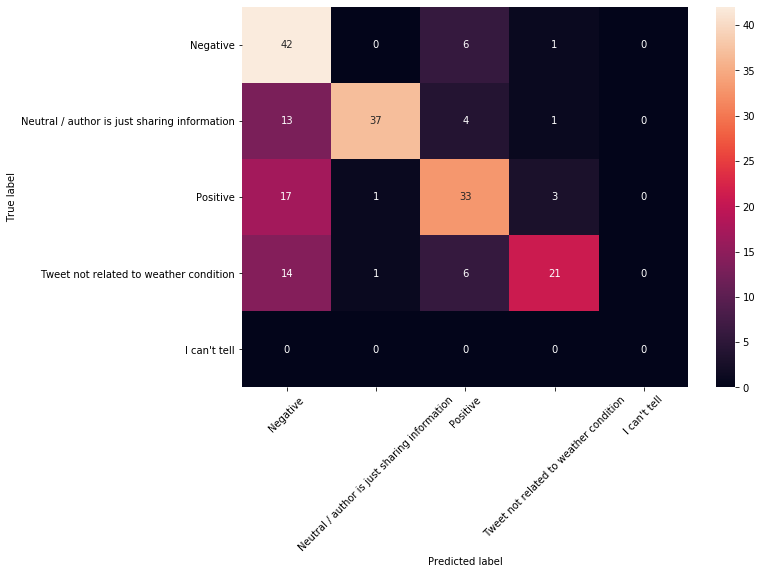

In [13]:
from sklearn.metrics import precision_recall_fscore_support,classification_report, confusion_matrix

# TODO: get the class names from the data
class_names = train_data.emotion.unique()

def plot_confusion_matrix(y_test,y_predicted,labels):
    cm = confusion_matrix(y_test, y_predicted,labels =labels)

    figsize = (10,7)
    df_cm = pd.DataFrame(
        cm, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def evaluate_classifier(pipeline, x_test, y_test):
    # TODO: get the predictions
    y_predicted = pipeline.predict(x_test)
    # TODO: generate the report
    report  = classification_report(y_test, y_predicted)
    print(report)
    # TODO: plot the confusion matrix
    plot_confusion_matrix(y_test, y_predicted, class_names)

evaluate_classifier(pipeline, x_test,y_test)

We can experiment with other classifiers as we please at this point. Try using an SVM classifier and a RandomForestClassifier classifier instead. You might notice that the Multinomial Naive Bayes is already a good baseline for short text classification.


                                              precision    recall  f1-score   support

                                I can't tell       0.00      0.00      0.00         0
                                    Negative       0.51      0.63      0.56        49
Neutral / author is just sharing information       0.85      0.71      0.77        55
                                    Positive       0.66      0.57      0.61        54
      Tweet not related to weather condition       0.56      0.60      0.57        42

                                    accuracy                           0.63       200
                                   macro avg       0.51      0.50      0.50       200
                                weighted avg       0.65      0.63      0.64       200



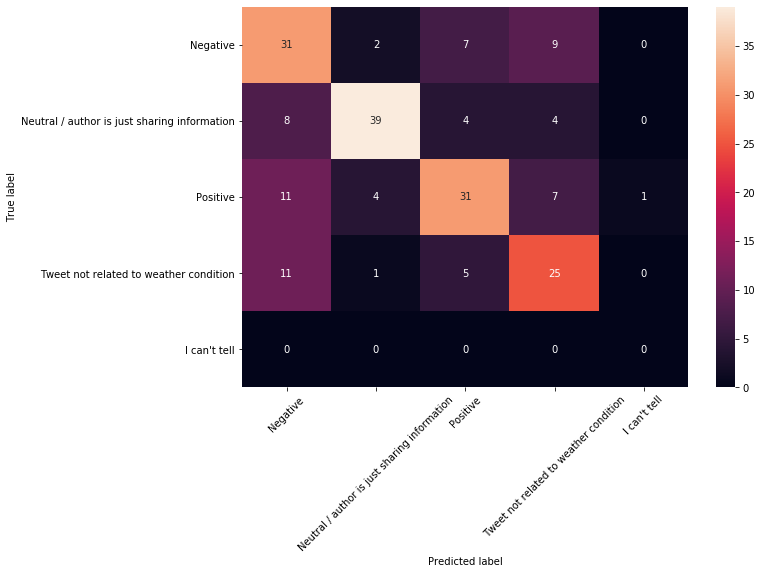

                                              precision    recall  f1-score   support

                                    Negative       0.52      0.88      0.65        49
Neutral / author is just sharing information       0.90      0.64      0.74        55
                                    Positive       0.71      0.46      0.56        54
      Tweet not related to weather condition       0.58      0.60      0.59        42

                                    accuracy                           0.64       200
                                   macro avg       0.68      0.64      0.64       200
                                weighted avg       0.69      0.64      0.64       200



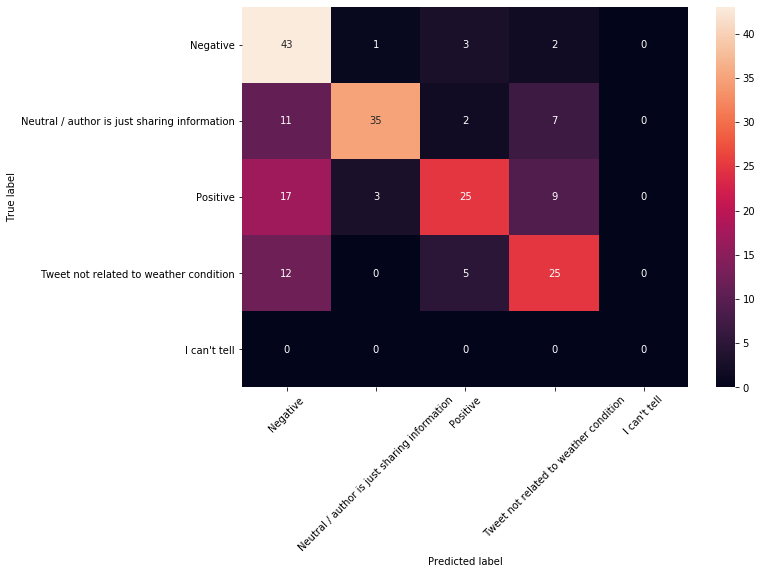

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# TODO: build the pipeline with an SGDClassifier (SVM) and evaluate it
pipeline = build_pipeline(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),x_train,y_train)
evaluate_classifier(pipeline, x_test,y_test)

# TODO: build the pipeline with a Random Forest Classifier and evaluate it
pipeline = build_pipeline(RandomForestClassifier(n_estimators=500),x_train,y_train)
evaluate_classifier(pipeline, x_test,y_test)

### Task 5: Predicting Emotions for New Tweets

It's worth noting that as have the classifiers, we can try them a couple of new tweets.

In [15]:
tweets = ["love the weather","#WEATHER: 7:51 am E: 55.0F. Feels F. 30.01% Humidity. 3.5MPH Variable Wind."]
# TODO: get the predictions
predictions = pipeline.predict(tweets)
predictions

array(['Positive', 'Neutral / author is just sharing information'],
      dtype=object)

### Task 6: Visualizing a Decision Tree Classifier

side note: this requires the installation of **graphviz**

One way to see how our features are affecting the classification is to use interpretable classifiers like Decision Trees. To begin with, let's add another step to our pipeline, where we use TF-IDF measure for each word as a vector element instead of taking the term frequency only. We'll use the [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

# TODO: build a new pipeline with the TfidfTransformer
def build_pipeline(classifier_fn,x_train,y_train):
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2),max_df=0.5)),
        ('tfidf_transformer',  TfidfTransformer()),
        ('classifier',          classifier_fn)
        ])
    pipeline.fit(x_train,y_train)
    return pipeline

Now we're ready to build and visualize the decision tree.

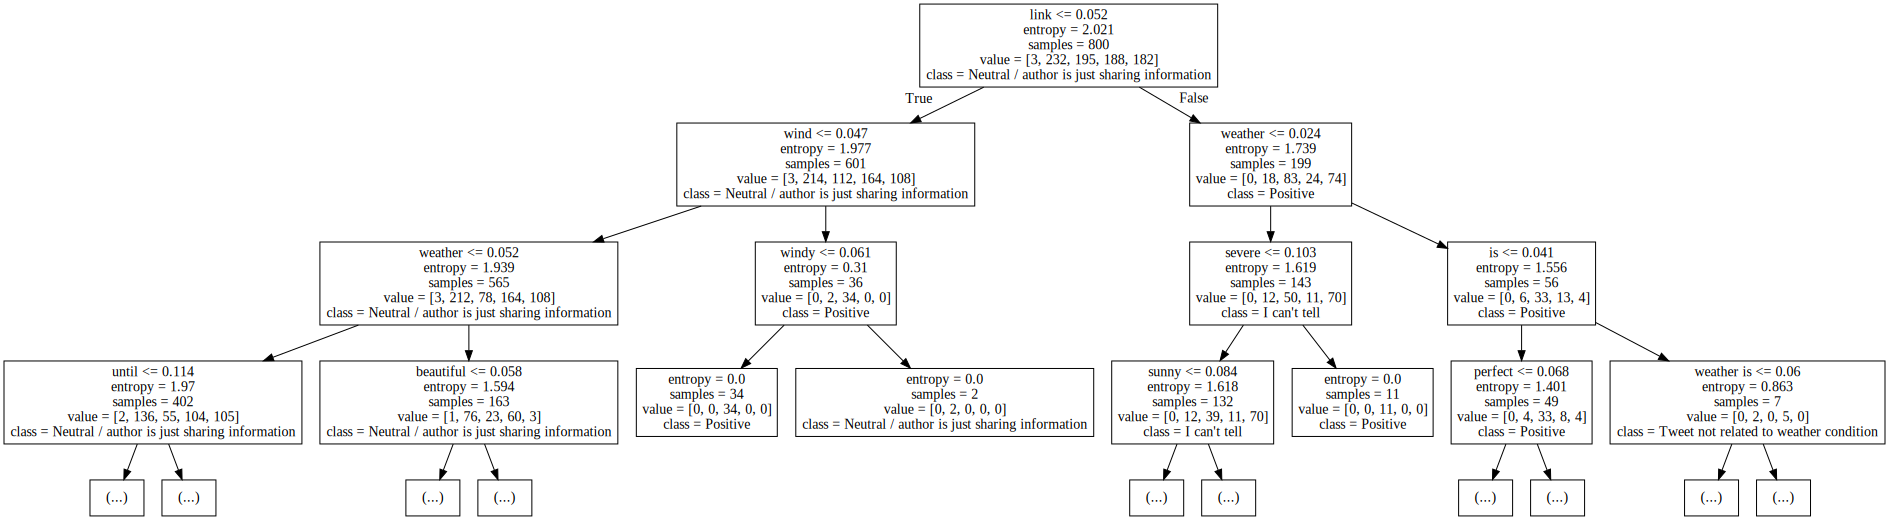

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# TODO: build the pipeline with the Decision Tree Classifier
pipeline = build_pipeline(DecisionTreeClassifier(criterion="entropy"), x_train, y_train)
# extract the classifier and the count_vectorizer from the pipeline
classifier= pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
# TODO: Use export_graphviz to visualize the classifiers. You already have all the needed parameters.
dot_data = export_graphviz(classifier, out_file=None,max_depth=3,
                           feature_names=count_vectorizer.get_feature_names(),class_names=class_names) 

graph = graphviz.Source(dot_data) 
graph

### Task 7 Get Feature Importance

One way to debug our classifiers and see how they are working is to investigate the features and print the most important ones. We'll do that next. But to start, let's do one more preprocessing step that further removes some of the noise: removing stop words.

In [18]:
from nltk.corpus import stopwords

# remove stopwords in order to improve interpretability
stop = stopwords.words('english')
stop += ['rt','@mention:','@mention','link']

# TODO: write a function that removes the stop words from each string in a numpy array of strings 
def remove_stopwords(x_train):
    return np.array( [' '.join([word for word in sample.split() if word.lower() not in stop]) for sample in x_train])


x_train_nostop = remove_stopwords(x_train)
x_test_no_stop = remove_stopwords(x_test)

print(x_train_nostop)

['Mad windy reason'
 '#WEATHER: 1:56 pm : 77.0F. Feels F. 29.96% Humidity. 11.5MPH South Wind.'
 'went Colombia month least beautiful weather'
 'Follow #Glee #Herecomestheboom #sunshine @mention!!'
 'hot #Truck outside'
 'Heavy Dust Storm Blankets Parts Chandler: good sized dust storm blew east valley blanketing par... {link}'
 'rrrrriiight yu tellin idk weather mad cry -__-'
 'Needless say, scorching out. still hot back inside quite time now.'
 'Waking beautiful weather- great day be!'
 'brought sunshine LA... also brought traffic! #SMUGGLERSTOUR {link}'
 'nothing better woman warm weather #yeahiamthattype'
 'Tatum, NM @ 12:00 PM: Temp:90F(H 91/L 55), Hum: 3&#x25;, DewPt:-1F, Wind: WSW 18 G 28.0 mph, Rain:0.00 In. #weather'
 'BREAKING: Large, wedge tornado ground coming Okla City LIVE weather blog {link} ...'
 'Thx - sounds like gone crazy weather...'
 'Gardner WX 05/18/11 03:00 | 49F, 55&#x25; Humidity, Feels Like 49F | Alerts: CURRENT ADVISORIES | {link}'
 '#WEATHER: 2:53 pm : 57.0F

Now we're ready to get the most important features for each class. Complete the function below with the missing lines. An easy sanity check is to see if the words that are important for the "Positive" class are actually positive and vice-versa!

In [19]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=20):
    labelid = list(classifier.classes_).index(classlabel)
    # TODO: get the feature names from the vectorizer
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)

        
pipeline = build_pipeline(MultinomialNB(),x_train_nostop,y_train)
# TODO: get the most informative features for a Multinomial NB classifier 
# by using the function above for the classes "Positive" and "Negative"
classifier= pipeline.get_params()['classifier']
count_vectorizer = pipeline.get_params()['count_vectorizer']
most_informative_feature_for_class(count_vectorizer,classifier,"Positive")

Positive happy -8.167105370076703
Positive finally -8.163054442433658
Positive makes -8.155788118209218
Positive today -8.12936289072837
Positive enjoying -8.12908076791711
Positive nice weather -8.108974715604274
Positive outside -8.095167728017183
Positive great -8.074434909293212
Positive morning -8.038994924864722
Positive link -8.037376163511277
Positive good -8.036455050714537
Positive degrees -8.012005056323654
Positive perfect -7.963658872955104
Positive love -7.914710442975588
Positive day -7.678999780293217
Positive nice -7.643505859990732
Positive beautiful -7.629275515782711
Positive sunny -7.2373770186369315
Positive weather -7.074430227335949
Positive sunshine -6.9929785054507665


In [20]:
most_informative_feature_for_class(count_vectorizer, classifier, "Negative")

Negative rain -8.151455463032791
Negative today -8.146935838772041
Negative still -8.132774698100672
Negative link -8.120673604400697
Negative need -8.100970354207961
Negative bad -8.0695325589857
Negative day -8.068365743079426
Negative hot outside -8.056415229357803
Negative rainy -7.946403359386876
Negative back -7.943582026771534
Negative like -7.936491955818804
Negative degrees -7.920126381297873
Negative windy -7.916166188287877
Negative damn -7.858302778808009
Negative storm -7.841551585781593
Negative cold -7.592933100297483
Negative outside -7.329479932883273
Negative hot -7.26661213343989
Negative freezing -7.178469765384323
Negative weather -6.974350363683126


In [21]:
most_informative_feature_for_class(count_vectorizer, classifier, "Neutral / author is just sharing information")

Neutral / author is just sharing information 53 -8.096408895455305
Neutral / author is just sharing information county -8.094703259426685
Neutral / author is just sharing information thunderstorm warning -8.020326510819864
Neutral / author is just sharing information may -8.001730374367181
Neutral / author is just sharing information warning -7.938555825751385
Neutral / author is just sharing information severe thunderstorm -7.908801190414684
Neutral / author is just sharing information 00 -7.87762310049311
Neutral / author is just sharing information feels 29 -7.855485793638784
Neutral / author is just sharing information thunderstorm -7.846426921786479
Neutral / author is just sharing information storm -7.771794473663107
Neutral / author is just sharing information severe -7.691695413577734
Neutral / author is just sharing information 29 -7.61299967371869
Neutral / author is just sharing information 0f -7.531026138993462
Neutral / author is just sharing information 0f feels -7.531026

### Task 8: Cross validation

Above, we were using a training set and a testing set for evaluating our models. A more robust way to evaluate a model is to use cross validation. In the code below, we will do such evaluation. At the same time, we will use the cross-validation results to select better parameters for our model. More specifically, we will find a good `alpha` parameter for the `MultinomialNB` model. Hence, we will plot the variation of the F1 score for the "Positive" and the "Negative" labels.

In [22]:
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold


# construct a new X and y 
X = np.concatenate((x_train_nostop, x_test_no_stop),axis=0)
y = np.concatenate((y_train, y_test),axis=0)  

# prepare for the cross validation 
kf = StratifiedKFold(n_splits=5,random_state=4)

alphas = [(i*0.1) for i in range(0,10)]


total_f1_pos = []
total_f1_neg = []

for a in alphas:
    f_score_pos = []
    f_score_neg = []
    for train_index, test_index in kf.split(X,y):
        
        # TODO: build the pipeline for the current alpha and the current training and testing set 
        pipeline = build_pipeline(MultinomialNB(alpha=a),X[train_index],y[train_index])
       
        y_predicted = pipeline.predict(X[test_index])
        report  = precision_recall_fscore_support(y[test_index], y_predicted)
        
        # let's get the f1_score value for the "Positive" and the "Negative" labels to plot them
        
        ind_pos = list(pipeline.classes_).index('Positive')
        ind_neg = list(pipeline.classes_).index('Negative')

        # report 0 is precision
        # report 2 is f-score
        fscore_positive = report[0][ind_pos]
        fscore_negative = report[0][ind_neg]
        
        f_score_pos += [fscore_positive]
        f_score_neg += [fscore_negative]
    # TODO: extend the arrays with the average  fscore_positive and fscore_negative repsectively.
    total_f1_pos += [np.mean(f_score_pos)]
    total_f1_neg += [np.mean(f_score_neg)]
    

We now plot the variation of the F1 score with different `alpha` values.

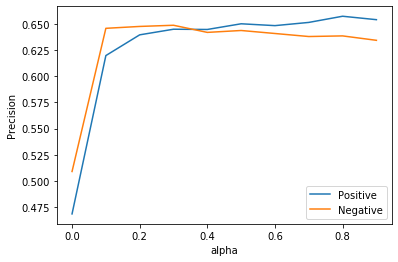

In [23]:
plt.plot(alphas,total_f1_pos,label='Positive')
plt.plot(alphas,total_f1_neg,label='Negative')

plt.xlabel('alpha')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Bonus Task 9: Food for thought

There is a lot of room for improvement in the above problem. Here are some issues to think about:
- You can see a lot of numbers and measures of wind speed or humidity in the dataset. Can we do some custom tokenization to group these similar features into a single one?
- Can we alternatively discretize these measures and turn them into discrete features like low/high wind speed? If people are expressing sentiment based on temperature, humdity, etc., this could be a good potential classifier which can work well in practice.
- You have seen that some of the labels have no predictions in the testing set. This is due to the imbalanced dataset. What can we do to improve this?